## Homework 4: Model evaluation

## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

In [21]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [23]:
def clean_data(df, columns, labels):
    df_clean = df[columns].fillna(0)
    df_clean = df_clean.join(df[labels])
    df_clean.columns = df_clean.columns.str.replace(' ', '_').str.lower()
    df_clean = df_clean.rename(columns={'msrp':'price'})
    
    return df_clean

In [24]:
def make_price_binary(df):
    price_mean = df['price'].mean()
    df['above_average'] = df['price'].apply(lambda x: 1 if x > price_mean else 0)
    del df['price'] 
    
    return df

In [25]:
def split_data(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    return df_train, df_val, df_test

In [37]:
def prepare_data_dict(split_df, label):
    y = split_df[label].values
    split_df_copy = splot_df.copy()
    del split_df_copy[label]
    
    train_dict = split_df_copy.to_dict(orient='records')
    
    return train_dict, y

In [27]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [28]:
columns = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type',
                       'Vehicle Style','highway MPG','city mpg']
labels = ['MSRP']

In [29]:
df_clean = clean_data(df, columns, labels)
df_clean = make_price_binary(df_clean)
df_clean.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [30]:
df_train, df_val, df_test = split_data(df_clean)
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp` <--
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [31]:
def find_feature_aucs(df, columns, labels):
    
    auc_dict = {}
    
    for col in columns:
        col_auc = roc_auc_score(df[labels], df[col])
        if col_auc < 0.5:
            col_auc = roc_auc_score(df[labels], -df[col])
        auc_dict[col] = col_auc
        
    return auc_dict

In [32]:
numerical = ['engine_hp', 'engine_cylinders' , 'highway_mpg', 'city_mpg']
find_feature_aucs(df_train, numerical, 'above_average')

{'engine_hp': 0.9171031265539011,
 'engine_cylinders': 0.766116490165669,
 'highway_mpg': 0.6330587871772013,
 'city_mpg': 0.6734244643245233}

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [33]:
X_train_dict, y_train = prepare_data_dict(df_train, 'above_average')
X_train_val, y_val = prepare_data_dict(df_val, 'above_average')

In [34]:
dv = DictVectorizer()

X_train = dv.fit_transform(X_train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [42]:
X_val = dv.transform(X_train_val)
y_pred_val = model.predict(X_val)

In [43]:
roc_auc_score(y_pred_val, y_val)

0.9159020217729393

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48 <--
* 0.68
* 0.88



In [51]:
y_val_pred_probs = model.predict_proba(X_val)[:,1]

thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_val_pred_probs >= t)
    predict_negative = (y_val_pred_probs < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores.tail()

,threshold,tp,fp,fn,tn,recall,precision
96,0.96,255,1,399,1728,0.389908,0.996094
97,0.97,237,1,417,1728,0.362385,0.995798
98,0.98,211,0,443,1729,0.322630,1.000000
99,0.99,181,0,473,1729,0.276758,1.000000
100,1.00,0,0,654,1729,0.000000,NaN


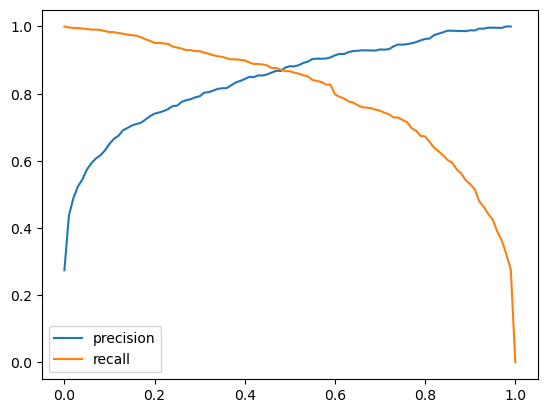

In [52]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52   <--
- 0.72

In [53]:
df_scores['f1'] = 2* (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
df_scores.head()

,threshold,tp,fp,fn,tn,recall,precision,f1
0,0.00,654,1729,0,0,1.000000,0.274444,0.430688
1,0.01,652,839,2,890,0.996942,0.437290,0.607925
2,0.02,651,680,3,1049,0.995413,0.489106,0.655919
3,0.03,651,592,3,1137,0.995413,0.523733,0.686347
4,0.04,650,543,4,1186,0.993884,0.544845,0.703844


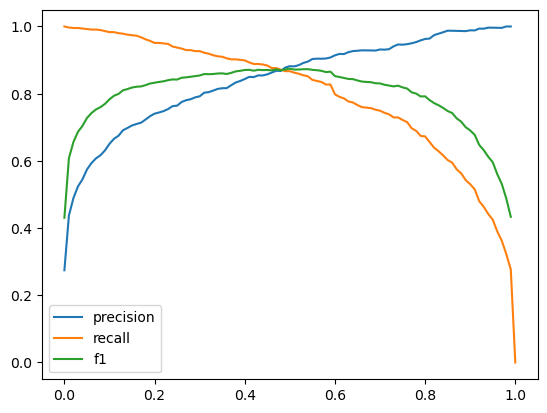

In [54]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()